In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
!pip install pmdarima
from pmdarima import auto_arima
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.arima.model import ARIMA

In [2]:
from statsmodels.tsa.stattools import arma_order_select_ic
from sklearn.metrics import mean_squared_error
from math import sqrt

In [139]:
import pandas as pd

abspath = "C:/Users/HHGiang/Documents/KEIO/3FZ/"
data = pd.read_excel(abspath + 'Giang.Marriott.xlsx', index_col=0)

# Drop rows with missing values
data = data.dropna()

In [140]:
data.tail()

,DEMAND,TUESDAY BOOKINGS,PICKUP RATIO,DOW INDEX,ADJUSTED
DATE,,,,,
1987-08-13,1093.0,932,1.172747,1.122727,1.044552
1987-08-14,1217.0,969,1.255934,1.048626,1.197695
1987-08-15,1542.0,1562,0.987196,0.864773,1.141567
1987-08-16,988.0,1004,0.984064,0.910585,1.080694
1987-08-17,1510.0,1404,1.075499,0.972883,1.105476


In [141]:
demand = data['DEMAND']
tue = data['TUESDAY BOOKINGS']
pickup = data['PICKUP RATIO']
dow = data['DOW INDEX']
adj = data['ADJUSTED']

<Axes: xlabel='DATE'>

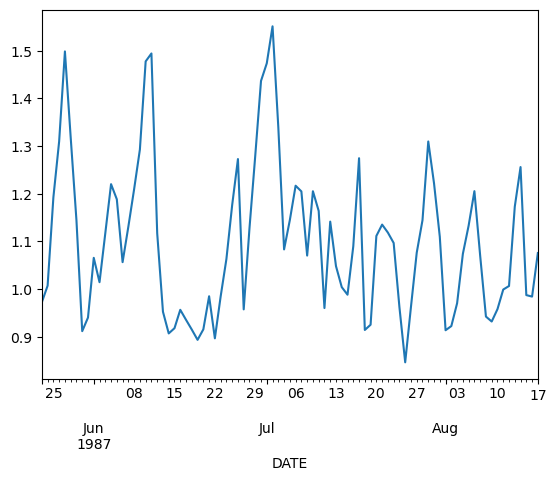

In [142]:
pickup.plot()

In [143]:
datatest = adfuller(data['PICKUP RATIO'], autolag = 'AIC')
print('1. ADF :', datatest[0] )
print('2. p-value :', datatest[1]) # == 0.015 so stationary SL 5%
print('3. num of lags :', datatest[2])
print('4. num of obs :', datatest[3])
print('5. critical values :', datatest[4])
for key, val in datatest[4].items():
    print("\t", key, ': ', val)

1. ADF : -3.295667135368632
2. p-value : 0.015073268089713118
3. num of lags : 7
4. num of obs : 79
5. critical values : {'1%': -3.5159766913976376, '5%': -2.898885703483903, '10%': -2.5866935058484217}
	 1% :  -3.5159766913976376
	 5% :  -2.898885703483903
	 10% :  -2.5866935058484217


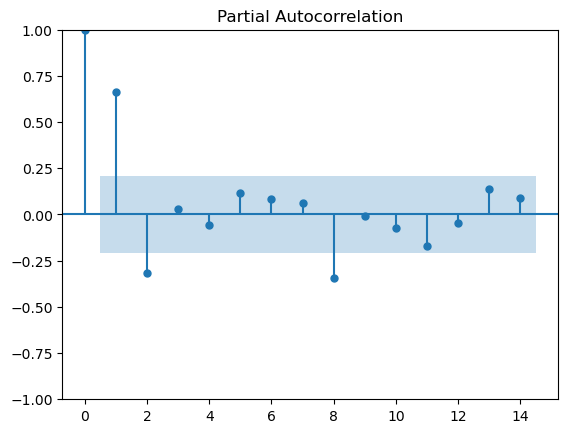

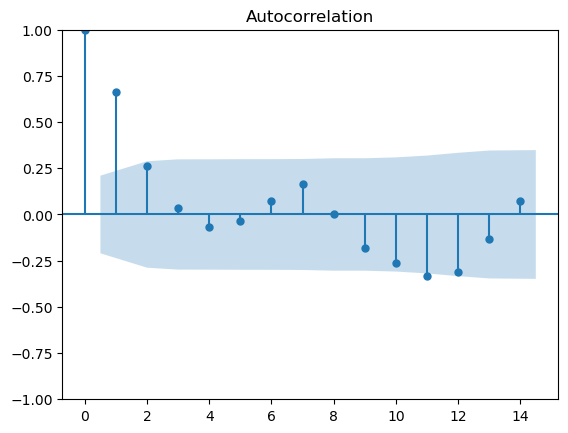

In [144]:
pacf = plot_pacf(pickup, lags = 14, method='ywm') # AR(1)
acf = plot_acf(pickup, lags = 14) # MA (2)

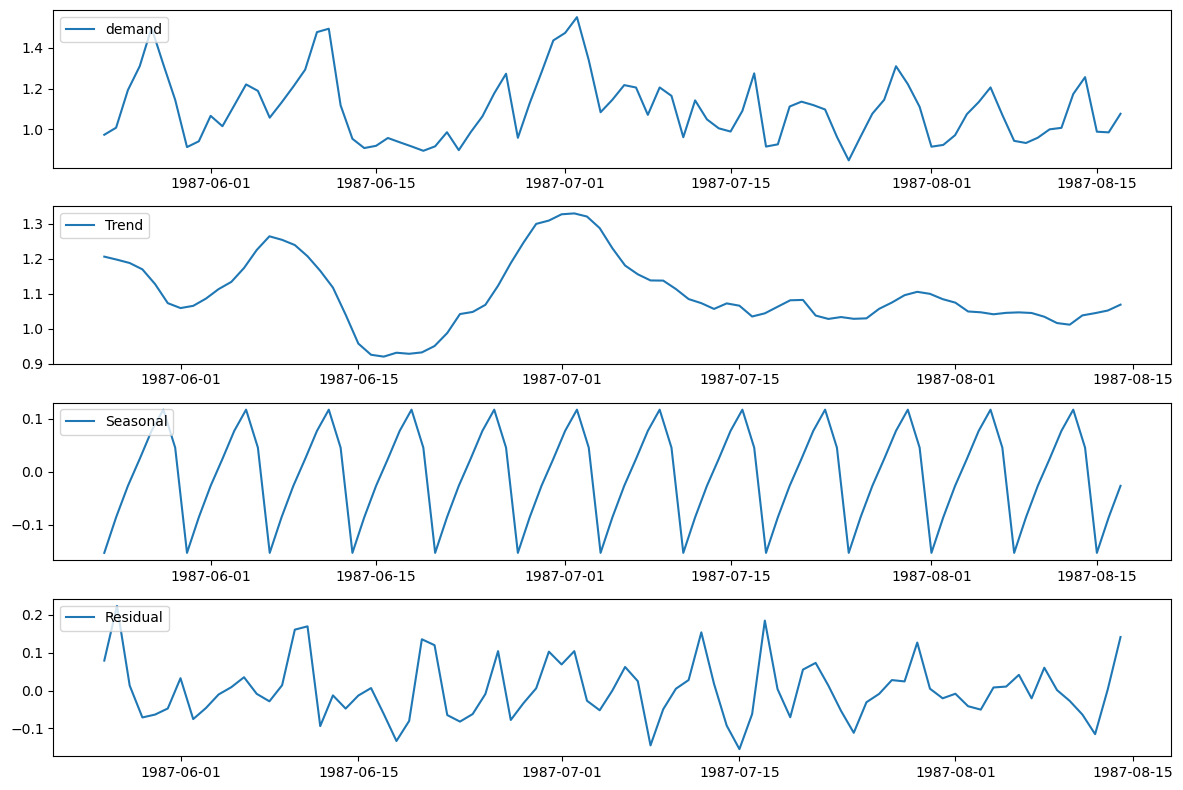

In [162]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

def stl_analysis(pickup):
    # Perform STL decomposition
    decomposition = sm.tsa.seasonal_decompose(pickup, model='additive')

    # Plot the decomposed components
    plt.figure(figsize=(12, 8))
    plt.subplot(411)
    plt.plot(pickup, label='demand')
    plt.legend(loc='upper left')
    plt.subplot(412)
    plt.plot(decomposition.trend, label='Trend')
    plt.legend(loc='upper left')
    plt.subplot(413)
    plt.plot(decomposition.seasonal, label='Seasonal')
    plt.legend(loc='upper left')
    plt.subplot(414)
    plt.plot(decomposition.resid, label='Residual')
    plt.legend(loc='upper left')
    plt.tight_layout()

    plt.show()

# Call the function with your DataFrame
stl_analysis(pickup) #clear seasonality (7)

In [170]:
from pmdarima import auto_arima

stepwise_model = auto_arima(pickup, 
                            start_p=0, start_q=0, max_p=7, max_q=7,
                            trace=True,  # To see progress
                            error_action='ignore', 
                            suppress_warnings=True, 
                            stepwise=True)  # To make it faster

print(stepwise_model.aic()) # Best model:  ARIMA(2,0,0)(1,0,1)[7] intercept

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-67.144, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-115.487, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-116.360, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=267.386, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-122.250, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-120.661, Time=0.12 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-120.333, Time=0.14 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-120.584, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-122.600, Time=0.04 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-120.635, Time=0.08 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-120.637, Time=0.19 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 0.932 seconds
-122.60044743759647


In [165]:
import statsmodels.api as sm

model = sm.tsa.statespace.SARIMAX(pickup,
                                  order=(2, 0, 0),
                                  enforce_stationarity=True,
                                  enforce_invertibility=True)

res = model.fit(disp=False)
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:           PICKUP RATIO   No. Observations:                   87
Model:               SARIMAX(2, 0, 0)   Log Likelihood                  51.269
Date:                Wed, 25 Oct 2023   AIC                            -96.538
Time:                        23:10:01   BIC                            -89.141
Sample:                    05-23-1987   HQIC                           -93.560
                         - 08-17-1987                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0917      0.110      9.962      0.000       0.877       1.306
ar.L2         -0.1001      0.108     -0.923      0.356      -0.313       0.112
sigma2         0.0172      0.003      5.470      0.0

In [148]:
87*0.8

69.60000000000001

In [149]:
data.head()

,DEMAND,TUESDAY BOOKINGS,PICKUP RATIO,DOW INDEX,ADJUSTED
DATE,,,,,
1987-05-23,1470.0,1512,0.972222,0.864773,1.124252
1987-05-24,870.0,864,1.006944,0.910585,1.105821
1987-05-25,986.0,827,1.192261,0.972883,1.225493
1987-05-26,1247.0,952,1.309874,1.012525,1.293671
1987-05-27,1109.0,740,1.498649,1.067881,1.403385


In [166]:
data_insample = data['1987-05-23':'1987-08-01']
data_insample.tail()

,DEMAND,TUESDAY BOOKINGS,PICKUP RATIO,DOW INDEX,ADJUSTED
DATE,,,,,
1987-07-28,1672.0,1461,1.144422,1.012525,1.130265
1987-07-29,1345.0,1027,1.309640,1.067881,1.226391
1987-07-30,1273.0,1042,1.221689,1.122727,1.088145
1987-07-31,1600.0,1442,1.109570,1.048626,1.058118
1987-08-01,1773.0,1941,0.913447,0.864773,1.056285


In [167]:
model = sm.tsa.SARIMAX(data_insample['PICKUP RATIO'], order=(2, 0, 0))
res = model.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:           PICKUP RATIO   No. Observations:                   71
Model:               SARIMAX(2, 0, 0)   Log Likelihood                  38.687
Date:                Wed, 25 Oct 2023   AIC                            -71.373
Time:                        23:10:21   BIC                            -64.585
Sample:                    05-23-1987   HQIC                           -68.674
                         - 08-01-1987                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0941      0.121      9.005      0.000       0.856       1.332
ar.L2         -0.1041      0.120     -0.868      0.385      -0.339       0.131
sigma2         0.0186      0.004      4.803      0.0

In [168]:
data_outsample = data['1987-08-02':]
data_outsample.tail()

,DEMAND,TUESDAY BOOKINGS,PICKUP RATIO,DOW INDEX,ADJUSTED
DATE,,,,,
1987-08-13,1093.0,932,1.172747,1.122727,1.044552
1987-08-14,1217.0,969,1.255934,1.048626,1.197695
1987-08-15,1542.0,1562,0.987196,0.864773,1.141567
1987-08-16,988.0,1004,0.984064,0.910585,1.080694
1987-08-17,1510.0,1404,1.075499,0.972883,1.105476


In [169]:
model = smt.ARIMA(data['PICKUP RATIO'], order=(2, 0, 0), seasonal_order=(1, 0, 1, 7))
res = model.fit()
res.predict('1987-08-02', '1987-08-17',dynamic=False)

1987-08-02    0.988814
1987-08-03    1.013658
1987-08-04    1.048882
1987-08-05    1.153643
1987-08-06    1.172934
1987-08-07    1.145537
1987-08-08    0.914446
1987-08-09    1.014159
1987-08-10    1.013537
1987-08-11    1.038801
1987-08-12    1.090451
1987-08-13    1.080248
1987-08-14    1.132488
1987-08-15    1.079698
1987-08-16    1.015931
1987-08-17    1.046375
Freq: D, Name: predicted_mean, dtype: float64

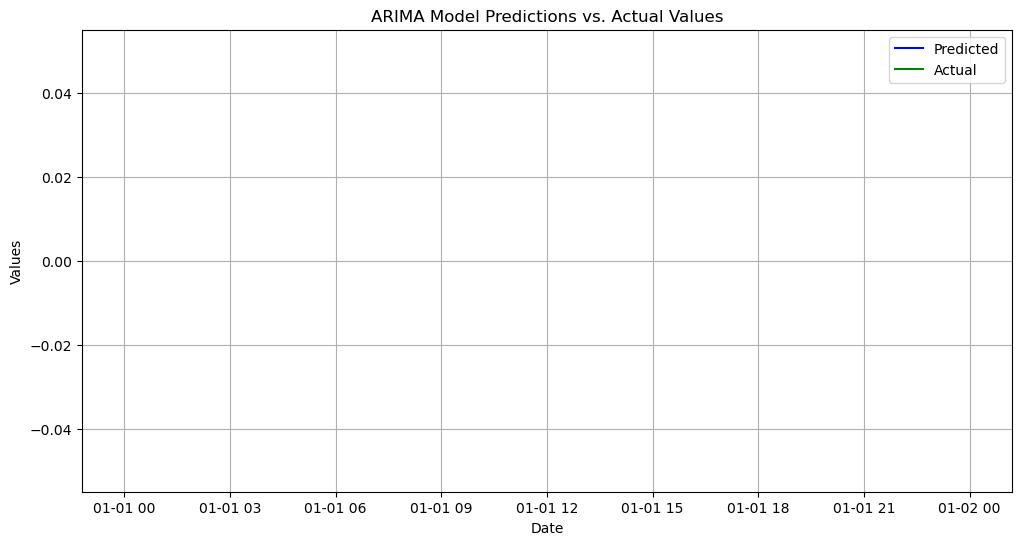

In [161]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'res.predict()' contains your predicted values and 'data_outsample' contains actual values
predicted_values = res.predict('1987-08-02', '1987-08-17', dynamic=False)

# Select the pickup column from 'data_outsample' for actual values
actual_data = data_outsample['PICKUP RATIO']

# Create a date range for the predicted values
date_range = pd.date_range(start='1987-08-02', end='1987-08-17', freq='MS')

# Create a DataFrame with the predicted and actual values and date index
predicted_df = pd.DataFrame({'Predicted': predicted_values, 'Actual': actual_data}, index=date_range)

# Plot both predicted and actual values
plt.figure(figsize=(12, 6))
plt.plot(predicted_df.index, predicted_df['Predicted'], label='Predicted', color='blue')
plt.plot(predicted_df.index, predicted_df['Actual'], label='Actual', color='green')
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('ARIMA Model Predictions vs. Actual Values')
plt.legend()
plt.grid(True)
plt.show()

In [172]:
def rmse(pred, target):
    return np.sqrt(((pred - target) ** 2).mean())
pred = res.predict('1987-08-02','1987-08-17',dynamic=False)
stats = rmse(pred, data_insample['PICKUP RATIO'])
print('Root Mean Squared Error (rmse function): {}'.format(stats))

pred = res.predict('1987-08-02','1987-08-17',dynamic=False)
stats1 = rmse(pred, data_outsample['PICKUP RATIO'])
print('Root Mean Squared Error (rmse function): {}'.format(stats1))

Root Mean Squared Error (rmse function): nan
Root Mean Squared Error (rmse function): 0.06506425067321651


In [115]:
datatest = adfuller(data['ADJUSTED'], autolag = 'AIC')
print('1. ADF :', datatest[0] )
print('2. p-value :', datatest[1]) # == 0.009 so stationary
print('3. num of lags :', datatest[2])
print('4. num of obs :', datatest[3])
print('5. critical values :', datatest[4])
for key, val in datatest[4].items():
    print("\t", key, ': ', val)

1. ADF : -3.444425369442226
2. p-value : 0.009534485677945457
3. num of lags : 0
4. num of obs : 86
5. critical values : {'1%': -3.5087828609430614, '5%': -2.895783561573195, '10%': -2.5850381719848565}
	 1% :  -3.5087828609430614
	 5% :  -2.895783561573195
	 10% :  -2.5850381719848565


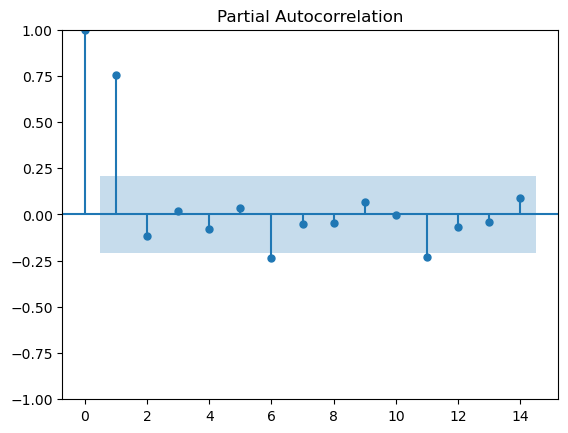

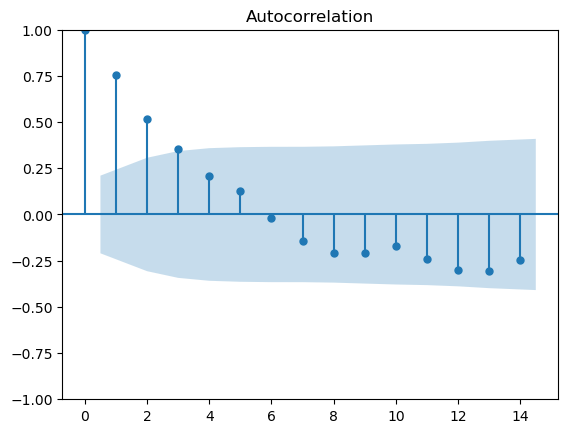

In [118]:
pacf = plot_pacf(adj, lags = 14, method='ywm') # AR(1)
acf = plot_acf(adj, lags = 14) # MA(5)

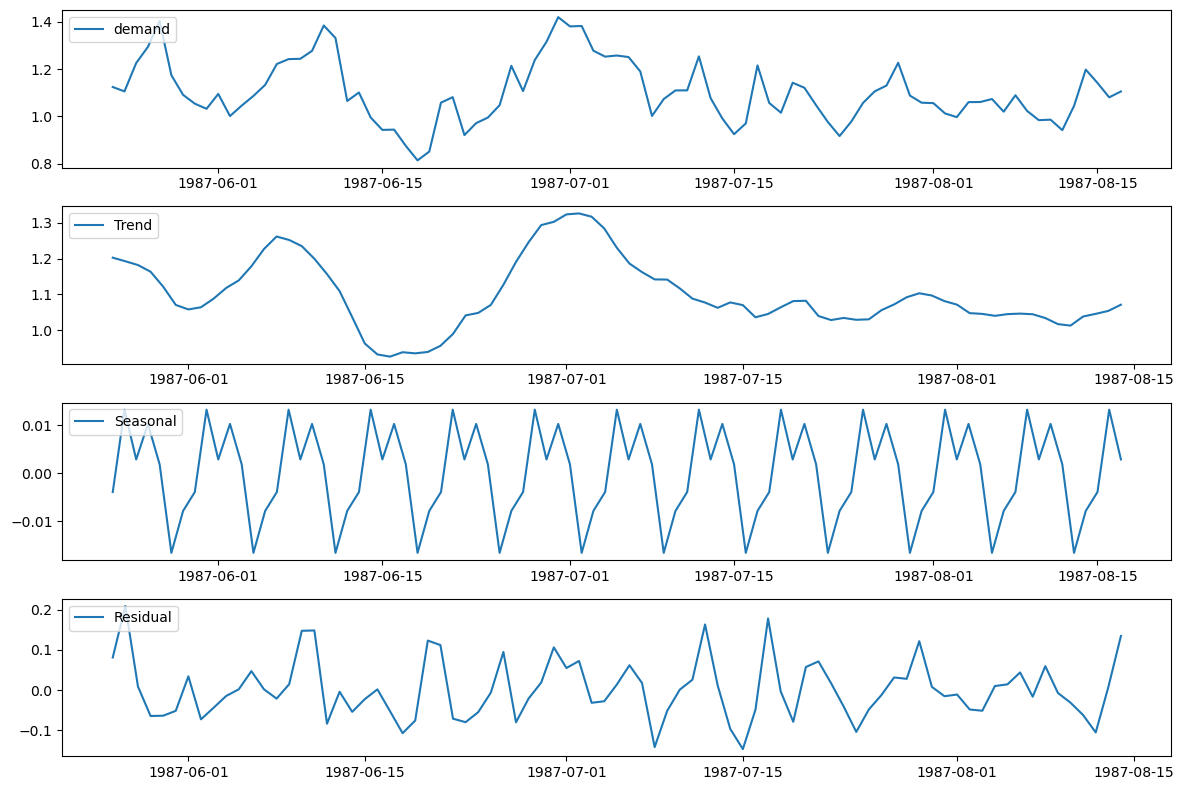

In [121]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

def stl_analysis(adj):
    # Perform STL decomposition
    decomposition = sm.tsa.seasonal_decompose(adj, model='additive')

    # Plot the decomposed components
    plt.figure(figsize=(12, 8))
    plt.subplot(411)
    plt.plot(adj, label='demand')
    plt.legend(loc='upper left')
    plt.subplot(412)
    plt.plot(decomposition.trend, label='Trend')
    plt.legend(loc='upper left')
    plt.subplot(413)
    plt.plot(decomposition.seasonal, label='Seasonal')
    plt.legend(loc='upper left')
    plt.subplot(414)
    plt.plot(decomposition.resid, label='Residual')
    plt.legend(loc='upper left')
    plt.tight_layout()

    plt.show()

# Call the function with your DataFrame
stl_analysis(adj)

In [171]:
from pmdarima import auto_arima

stepwise_model = auto_arima(adj, 
                            start_p=0, start_q=0, max_p=7, max_q=7,
                            trace=True,  # To see progress
                            error_action='ignore', 
                            suppress_warnings=True, 
                            stepwise=True)  # To make it faster

print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-104.456, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-174.374, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-156.355, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=267.298, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-173.533, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-173.619, Time=0.12 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-173.011, Time=0.20 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.531 seconds
-174.37434056552306


In [173]:
import statsmodels.api as sm

model = sm.tsa.statespace.SARIMAX(pickup,
                                  order=(1, 0, 0),
                                  enforce_stationarity=True,
                                  enforce_invertibility=True)

res = model.fit(disp=False)
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:           PICKUP RATIO   No. Observations:                   87
Model:               SARIMAX(1, 0, 0)   Log Likelihood                  50.810
Date:                Wed, 25 Oct 2023   AIC                            -97.621
Time:                        23:15:12   BIC                            -92.689
Sample:                    05-23-1987   HQIC                           -95.635
                         - 08-17-1987                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9940      0.013     76.853      0.000       0.969       1.019
sigma2         0.0173      0.003      5.623      0.000       0.011       0.023
Ljung-Box (L1) (Q):                   0.88   Jarque-

In [181]:
model = smt.ARIMA(data['ADJUSTED'], order=(1, 0, 0))
res = model.fit()
res.predict('1987-08-02', '1987-08-17',dynamic=False)

1987-08-02    1.068640
1987-08-03    1.036230
1987-08-04    1.024617
1987-08-05    1.071765
1987-08-06    1.072169
1987-08-07    1.081519
1987-08-08    1.041764
1987-08-09    1.093325
1987-08-10    1.044017
1987-08-11    1.015126
1987-08-12    1.016697
1987-08-13    0.983796
1987-08-14    1.059904
1987-08-15    1.173920
1987-08-16    1.132133
1987-08-17    1.086812
Freq: D, Name: predicted_mean, dtype: float64

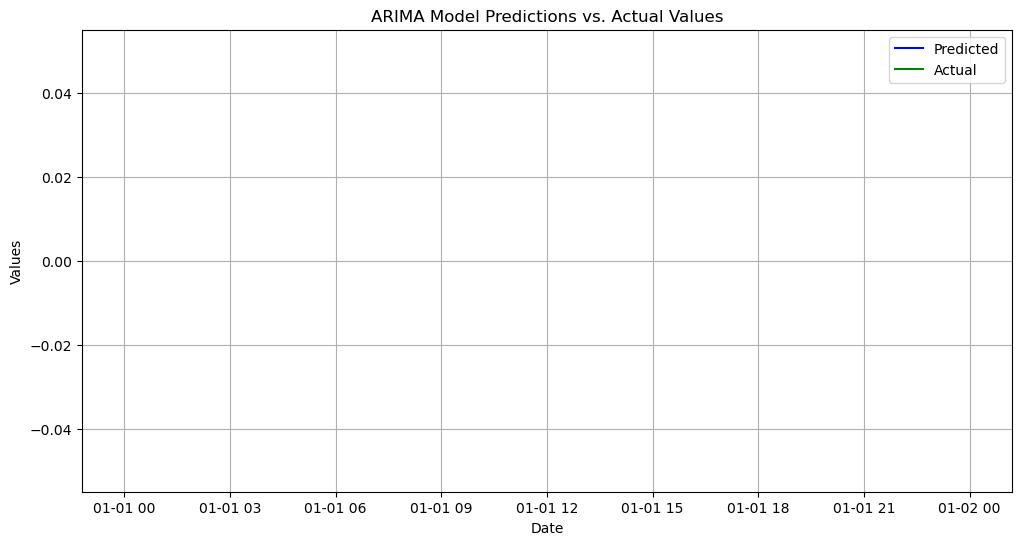

In [182]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'res.predict()' contains your predicted values and 'data_outsample' contains actual values
predicted_values = res.predict('1987-08-02', '1987-08-17', dynamic=False)

# Select the adj column from 'data_outsample' for actual values
actual_data = data_outsample['ADJUSTED']

# Create a date range for the predicted values
date_range = pd.date_range(start='1987-08-02', end='1987-08-17', freq='MS')

# Create a DataFrame with the predicted and actual values and date index
predicted_df = pd.DataFrame({'Predicted': predicted_values, 'Actual': actual_data}, index=date_range)

# Plot both predicted and actual values
plt.figure(figsize=(12, 6))
plt.plot(predicted_df.index, predicted_df['Predicted'], label='Predicted', color='blue')
plt.plot(predicted_df.index, predicted_df['Actual'], label='Actual', color='green')
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('ARIMA Model Predictions vs. Actual Values')
plt.legend()
plt.grid(True)
plt.show()

In [179]:
def rmse(pred, target):
    return np.sqrt(((pred - target) ** 2).mean())
data_insample = data['1987-05-23':'1987-08-01']
pred = res.predict('1987-05-23','1987-08-01',dynamic=False)
stats = rmse(pred, data_insample['PICKUP RATIO'])
print('Root Mean Squared Error (rmse function): {}'.format(stats))

data_outsample = data['1987-08-02':'1987-08-17']
pred = res.predict('1987-08-02','1987-08-17',dynamic=False)
stats1 = rmse(pred, data_outsample['PICKUP RATIO'])
print('Root Mean Squared Error (rmse function): {}'.format(stats1))

Root Mean Squared Error (rmse function): 0.12461208653024572
Root Mean Squared Error (rmse function): 0.11815195027521373


In [183]:
def rmse(pred, target):
    return np.sqrt(((pred - target) ** 2).mean())
data_insample = data['1987-05-23':'1987-08-01']
pred = res.predict('1987-05-23','1987-08-01',dynamic=False)
stats = rmse(pred, data_insample['ADJUSTED'])
print('Root Mean Squared Error (rmse function): {}'.format(stats))

data_outsample = data['1987-08-02':'1987-08-17']
pred = res.predict('1987-08-02','1987-08-17',dynamic=False)
stats1 = rmse(pred, data_outsample['ADJUSTED'])
print('Root Mean Squared Error (rmse function): {}'.format(stats1))

Root Mean Squared Error (rmse function): 0.09048667274954494
Root Mean Squared Error (rmse function): 0.05789283393053311


In [186]:
snow_re = ARIMA(data["ADJUSTED"], order=(1, 0, 0)).fit()
snow_re.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               ADJUSTED   No. Observations:                   87
Model:                 ARIMA(1, 0, 0)   Log Likelihood                  90.187
Date:                Wed, 25 Oct 2023   AIC                           -174.374
Time:                        23:47:38   BIC                           -166.977
Sample:                    05-23-1987   HQIC                          -171.396
                         - 08-17-1987                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1046      0.037     29.923      0.000       1.032       1.177
ar.L1          0.7445      0.067     11.153      0.000       0.614       0.875
sigma2         0.0073      0.001      5.748      0.000       0.005       0.010
===================================================================================
Ljung-Box (L1) (Q):                   0.81   Jarque-Bera (JB):                 0.47
Prob(Q):                              0.37   Prob(JB):                         0.79
Heteroskedasticity (H):               0.46   Skew:                             0.09
Prob(H) (two-sided):                  0.04   Kurtosis:                         2.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [192]:
DOW = np.array([1.013, 1.068, 1.123, 1.049, 0.865, 0.911, 0.973, 1.013, 1.068, 1.123, 1.049])
TUE = np.array([1657, 1643, 1124, 1074, 1839, 1862, 1886, 1696, 1002, 794, 1106])
ADJ = snow_re.forecast(len(DOW))
demand = DOW * TUE * ADJ
week = ["TUE", "WED", "THU", "FRI", "SAT", "SUN", "MON", "TUE", "WED", "THU", "FRI"]
demand.index = week
print(demand)

TUE    1855.228078
WED    1939.151688
THU    1394.769942
FRI    1244.806055
SAT    1757.494625
SUN    1874.023564
MON    2027.296384
TUE    1897.961424
WED    1182.178749
THU     985.005239
FRI    1281.635446
Name: predicted_mean, dtype: float64


In [191]:
ADJ*DOW

1987-08-18    1.119631
1987-08-19    1.180251
1987-08-20    1.240899
1987-08-21    1.159037
1987-08-22    0.955680
1987-08-23    1.006457
1987-08-24    1.074919
1987-08-25    1.119081
1987-08-26    1.179819
1987-08-27    1.240561
1987-08-28    1.158802
Freq: D, Name: predicted_mean, dtype: float64